In [1]:
%pip install xgboost
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tensorflow-2.13.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.13.0-cp311-cp311-win_amd64.whl (276.6 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import os
from typing import List
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns


-----------------------------------------------------------------------------------------------
Dataset
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

In [3]:
#Dataset link
#current_dir=os.path.dirname(os.path.realpath(__file__))
current_dir="C:/Users/riazr/Downloads/WNMA"
drone_filename = current_dir+"/data/2023.07.15.10_meters.csv"
noise_filename = current_dir+"/data/2023.07.15.bg_after_10_meters.csv"


-----------------------------------------------------------------------------------------------
Util Functions
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

In [4]:
def dt_lookup(s):
    """
    Helper func. This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.

    https://stackoverflow.com/questions/29882573/pandas-slow-date-conversion
    """
    return s.map({date: pd.to_datetime(date) for date in s.unique()})

In [5]:
def read_drone_sweep_file_and_merge(path) -> pd.DataFrame:
    """
    Takes in the path to an output file from drone_sweep. drone_sweep spreads the output of a single sweep over
    multiple lines. This combines those lines. So that:
    - one row is one whole sweep (180 bins)
    - row indexed by datetime timestamp
    - columns (ie bins) are floor(starting_bin_freq_hz)

    With current drone_sweep settings, this yields a dataframe with 180 rows

    :param path: filepath_or_buffer : str, path object, or file-like object
    :return: pd.DataFrame
    """
    # grouped.get_group('2023-07-15 11:03:17.299693').values[:, 6:].ravel() # todo delete this line

    # Read CSV drone_sweep output to Pandas DataFrame
    drone_df: pd.DataFrame = pd.read_csv(path, header=None, low_memory=False)

    # Index everything by datetime
    datetime = pd.DatetimeIndex(dt_lookup(drone_df[0] + drone_df[1]))
    drone_df.set_index(datetime, inplace=True)

    # Group according to datetime timestamp
    # find the number of bins we are expecting, so we can discard the others. Use mode for this
    expected_num_bins = drone_df.groupby(drone_df.index).apply(lambda x: x.values[:, 6:].ravel().size).mode()
    # filter out incomplete sweeps. ie where < 180 bins
    merged_df = drone_df.groupby(drone_df.index).filter(lambda x: x.values[:, 6:].ravel().size == expected_num_bins)
    # combine multiple rows corresponding to a single sweep/timestamp into one row, datetime indexed
    merged_df = merged_df.groupby(merged_df.index).apply(lambda x: pd.Series(x.values[:, 6:].ravel()))

    num_bins = merged_df.shape[1]
    # set col name to min freq for each sample i.e. sample starting at 2400000000 hz
    min_freq = drone_df[2].min()
    max_freq = drone_df[3].max()
    bin_size = (max_freq - min_freq) / num_bins  # in hz
    merged_df.columns = [int((min_freq + x * bin_size)) for x in range(0, num_bins)]

    # FIX for scatterplot -- make sure it contains FLOATS not STRINGS!
    merged_df = merged_df.astype(float)

    return merged_df

In [6]:
def get_mean_by_bin(df: pd.DataFrame) -> pd.Series:
    """
    Takes all the sweep data from the input dataframe as returned by read_drone_sweep_file_and_merge
    and gets the average db for each bin.
    Returns as a pandas Series

    :param df: pd.DataFrame from experiment in question
    :return: pd.Series of average
    """
    return df.mean(axis=0)


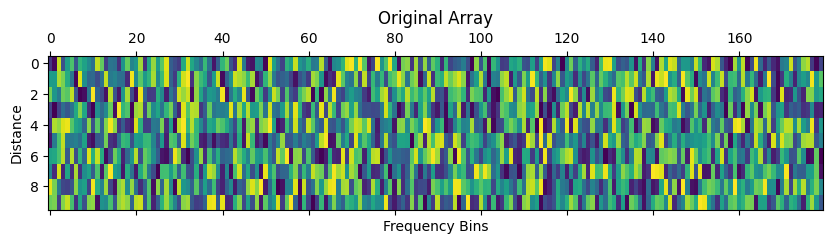

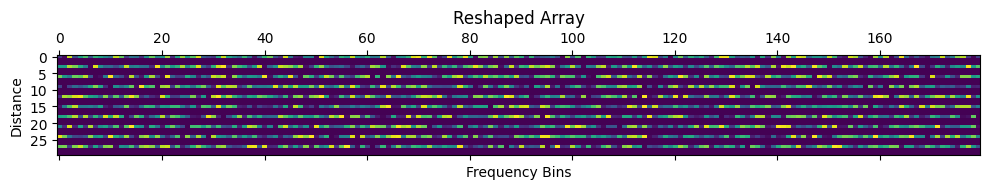

In [7]:
# testing
# Example original array with shape (10, 180)
original_array = np.random.random((10, 180))

# Calculate the number of empty rows needed
num_empty_rows = 2

# Initialize an empty list to store the final arrays
final_arrays = []

# Loop through the original array and add 5 empty arrays after each row
for row in original_array:
    final_arrays.append(row)
    for _ in range(num_empty_rows):
        final_arrays.append(np.zeros_like(row))

# Convert the list of arrays to a NumPy array
reshaped_array = np.array(final_arrays)

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 2))

# Plot the original array
ax1.matshow(original_array,cmap='viridis', aspect='auto')
ax1.set_title('Original Array')
ax1.set_xlabel('Frequency Bins')
ax1.set_ylabel('Distance')

fig, ax2 = plt.subplots(figsize=(10, 2))
# Plot the reshaped array
ax2.matshow(reshaped_array, cmap='viridis', aspect='auto')
ax2.set_title('Reshaped Array')
ax2.set_xlabel('Frequency Bins')
ax2.set_ylabel('Distance')

# Show the plots
plt.tight_layout()
plt.show()

In [8]:
def get_max_by_bin(df: pd.DataFrame) -> pd.Series:
    """
    Takes all the sweep data from the input dataframe as returned by read_drone_sweep_file_and_merge
    and gets the max db for each bin.
    Returns as a pandas Series

    :param df: pd.DataFrame from experiment in question
    :return: pd.Series of average
    """
    return df.max(axis=0)

In [9]:
def get_heat_map(avg_by_bin):
     # Heat Map
    # need to rename the '5 meter' file to '5' instead of '05' for this to work
    i = 5
    avgs_over_distance = avg_by_bin
    #print(avgs_over_distance.shape)

    while i <= 50:
        filename_dr = current_dir+f"/data/2023.07.15.{i}_meters.csv" 
        filename_bg = current_dir+f"/data/2023.07.15.bg_after_{i}_meters.csv"

        sample_dr = read_drone_sweep_file_and_merge(filename_dr)
        sample_bg = read_drone_sweep_file_and_merge(filename_bg)
        avg_by_bin_dr = get_mean_by_bin(sample_dr)
        avg_by_bin_bg = get_mean_by_bin(sample_bg)
        if i == 5:
            avgs_over_distance_dr=avgs_over_distance
            avgs_over_distance_bg=avgs_over_distance
            
        else:
            #.iloc[80:100]
            avgs_over_distance_dr = np.append(avgs_over_distance_dr, avg_by_bin_dr)
            avgs_over_distance_bg = np.append(avgs_over_distance_bg, avg_by_bin_bg)
        i = i + 5
    #print(avg_by_bin_dr.shape)
    #print("1. "+str(avgs_over_distance_bg.shape)+"\t"+str(avgs_over_distance_bg.shape)+"\n")
    #print("2. "+str(avgs_over_distance_dr.shape)+"\t"+str(avgs_over_distance_dr.shape)+"\n")

    avgs_over_distance_dr = np.reshape(avgs_over_distance_dr, (-1, 180))
    avgs_over_distance_bg = np.reshape(avgs_over_distance_bg, (-1, 180))
    #print("3. "+str(avgs_over_distance_bg.shape)+"\n")

 

    fig1,ax2D=plt.subplots(figsize=(10, 3))
    img=ax2D.matshow(avgs_over_distance_dr,cmap='viridis', aspect='auto')
    ax2D.set_title("Heat map of frequency bins with drone distance(Motors running)")
    

    # Set the custom y-axis ticks and labels
    custom_ticks = np.arange(5, 51, 5)
    custom_y_ticks_positions = np.linspace(0, avgs_over_distance_dr.shape[0] - 1, len(custom_ticks))

    # Show only specific labels on the y-axis
    y_tick_labels = ['5', '10', '15', '20', '25', '30', '35', '40', '45', '50']
    ax2D.set_yticks(custom_y_ticks_positions)
    ax2D.set_yticklabels(y_tick_labels)

    ax2D.set_ylabel('Distance')
    ax2D.set_xlabel('Frequency Bins')
    plt.colorbar(img, ax=ax2D, label="Signals + Environmental Noise + Motor Vibrations(db)",orientation='horizontal', spacing="proportional")
    savefig1=current_dir+"/figures/bin_distance_heatmap_dr.png"
    plt.savefig(savefig1)
    plt.show()

    fig2,ax3D=plt.subplots(figsize=(10, 3))
    img1=ax3D.matshow(avgs_over_distance_bg,cmap='viridis', aspect='auto')
    
    
    ax3D.set_title("Heat map of frequency bins regard to drone distance(Motors in Rest)")
    ax3D.set_yticks(custom_y_ticks_positions)
    ax3D.set_yticklabels(y_tick_labels)
    ax3D.set_ylabel('Distance')
    ax3D.set_xlabel('Frequency Bins')
    plt.colorbar(img1, ax=ax3D, label="Signals + Environmental Noise(db)",orientation='horizontal', spacing="proportional")
    savefig2=current_dir+"/figures/bin_noise_heatmap_bg.png"
    plt.savefig(savefig2)
    plt.show()


    std_dev = 0.2
    # Generate Gaussian noise with the same shape as the original array
    gaussian_noise = np.random.normal(loc=0, scale=std_dev, size=avgs_over_distance_bg.shape)

    # Add the noise to the original array
    noisy_array = avgs_over_distance_bg + gaussian_noise
    fig3,ax4D=plt.subplots(figsize=(10, 3))
    img2=ax4D.matshow(noisy_array,cmap='viridis', aspect='auto')
    ax4D.set_title("Heat map of frequency bins regard to drone distance(Motors in Rest)")
    ax4D.set_yticks(custom_y_ticks_positions)
    ax4D.set_yticklabels(y_tick_labels)
    ax4D.set_ylabel('Distance')
    ax4D.set_xlabel('Frequency Bins')
    plt.colorbar(img2, ax=ax4D, label="Signals + Environmental Noise + Gaussian Noise(db)",orientation='horizontal', spacing="proportional")
    savefig3=current_dir+"/figures/bin_noise_heatmap_bg.png"
    plt.savefig(savefig3)
    plt.show()
    

(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)
(180,)


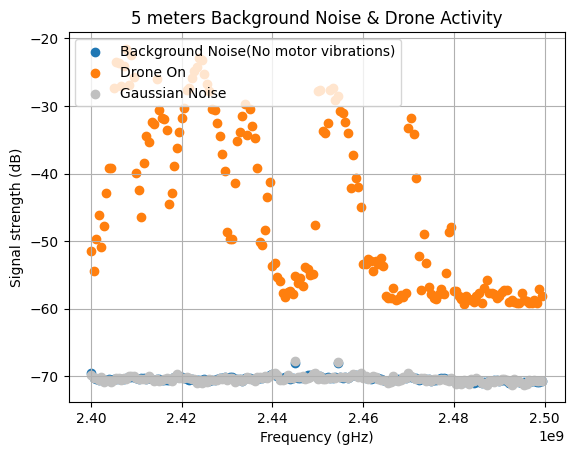

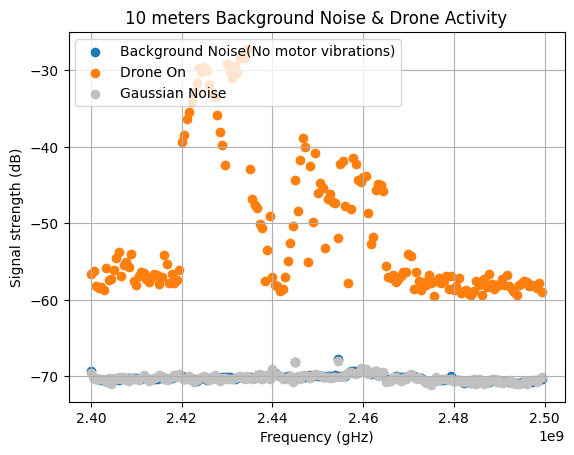

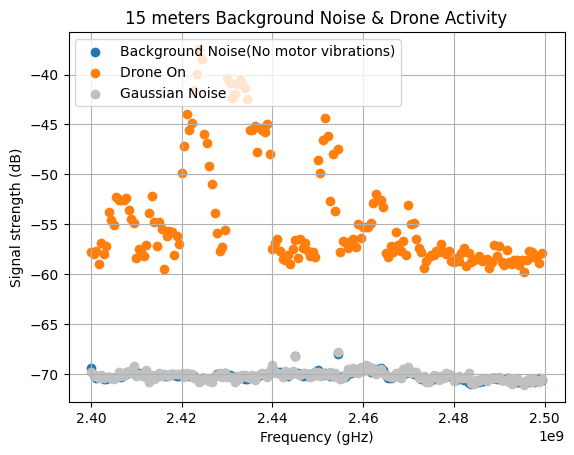

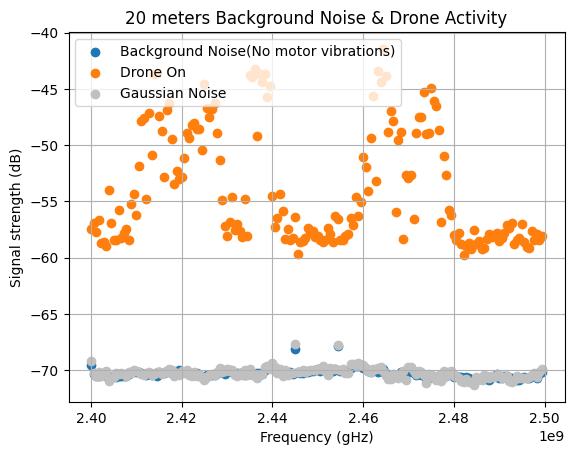

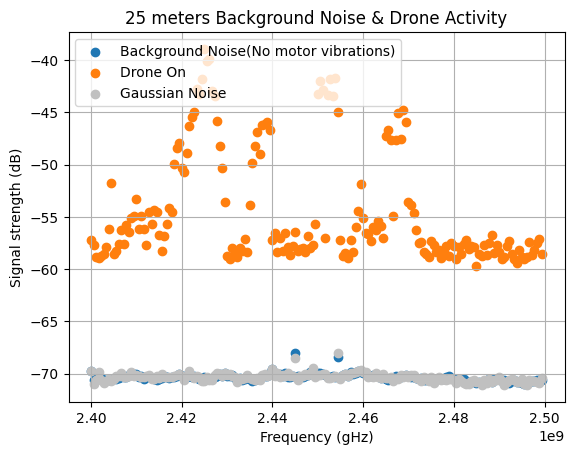

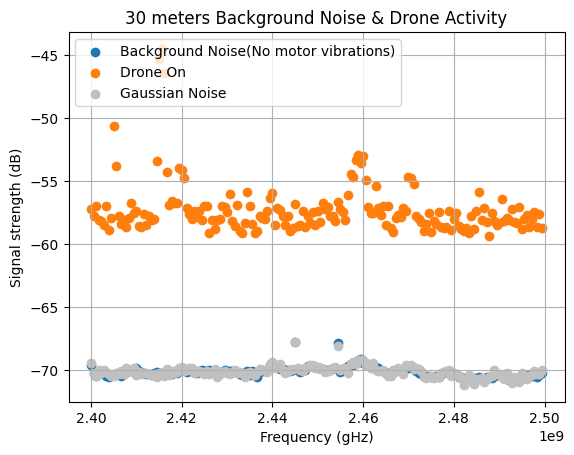

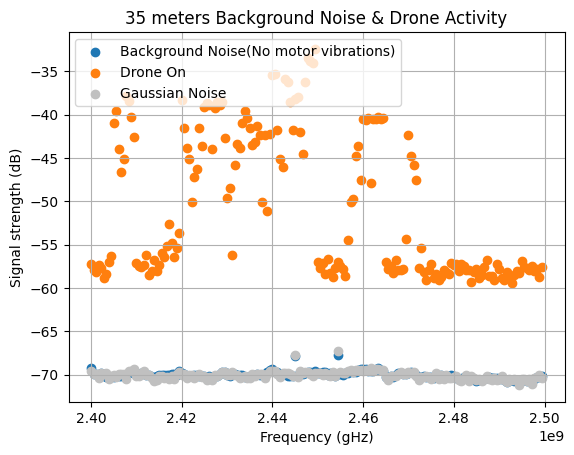

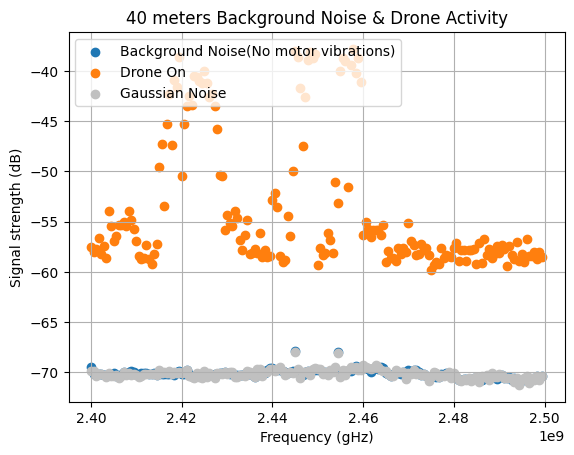

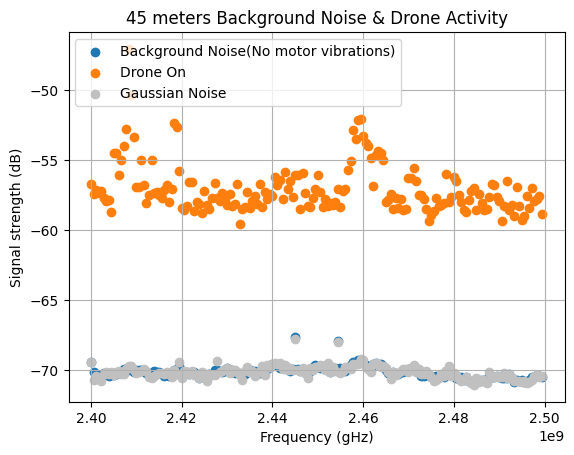

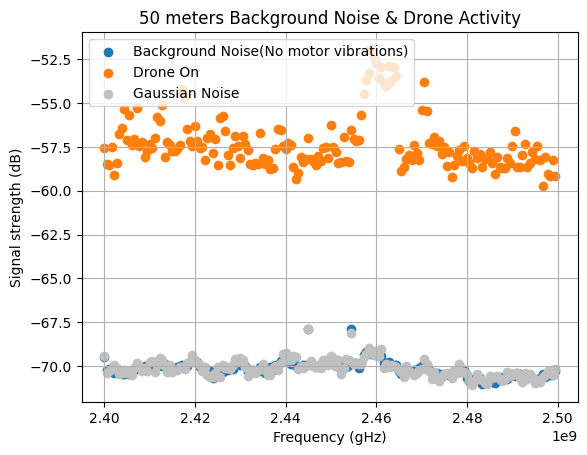

In [10]:

i = 5

#print(avgs_over_distance.shape)

while i <= 50:
    filename_dr = current_dir+f"/data/2023.07.15.{i}_meters.csv" 
    filename_bg = current_dir+f"/data/2023.07.15.bg_after_{i}_meters.csv"

    # Heat Map
    # need to rename the '5 meter' file to '5' instead of '05' for this to work
    sample_bg = read_drone_sweep_file_and_merge(filename_bg)
    sample_dr = read_drone_sweep_file_and_merge(filename_dr)

 
    max_by_bin_bg = get_mean_by_bin(sample_bg)
    max_by_bin_dr = get_max_by_bin(sample_dr)

    #add noise
    std_dev = 0.2
    # Generate Gaussian noise with the same shape as the original array
    gaussian_noise = np.random.normal(loc=0, scale=std_dev, size=max_by_bin_bg.shape)

    # Add the noise to the original array
    noisy_array = max_by_bin_bg + gaussian_noise

    print(max_by_bin_dr.shape)
    #avgs_over_distance_dr = np.reshape(avgs_over_distance, (-1, 180))
    fig1, ax1 = plt.subplots()

    ax1.scatter(max_by_bin_bg.index, max_by_bin_bg.values,color='C0', label="Background Noise(No motor vibrations)")
    ax1.scatter(max_by_bin_dr.index, max_by_bin_dr.values, color='C1', label="Drone On")
    ax1.scatter(noisy_array.index, noisy_array.values, color='silver', label="Gaussian Noise")

    plt.legend(loc='upper left')

    ax1.set_title(f"{i} meters Background Noise & Drone Activity")
    #plt.ylim(-75, -50)
    plt.xlabel("Frequency (gHz)")
    plt.ylabel("Signal strength (dB)")
    plt.grid(True)
    savefig=current_dir+f"/figures/{i}meters_comparison_scatter_MAX.png"
    plt.savefig(savefig)
    i = i + 5

-----------------------------------------------------------------------------------------------
Useful Visualization
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------


In [ ]:
print("Working in %s" % os.getcwd())
print("Using file %s" % drone_filename)
print("Example of reading in 10 meter drone data")
print("=======================================")
sample_data = read_drone_sweep_file_and_merge(drone_filename)
sample_data.info()  # just print out some info about the dataframe
print("---------------------------------------")
print(sample_data.head(5))
print("=======================================")
print("\nExample of getting avg for each bin (pandas Series):")
print("=======================================")
avg_by_bin = get_mean_by_bin(sample_data)
print("Shape: %s" % avg_by_bin.shape)
print("---------------------------------------")
print(avg_by_bin.head(4))
print("\t...")
print(avg_by_bin.tail(4))
print("=======================================")

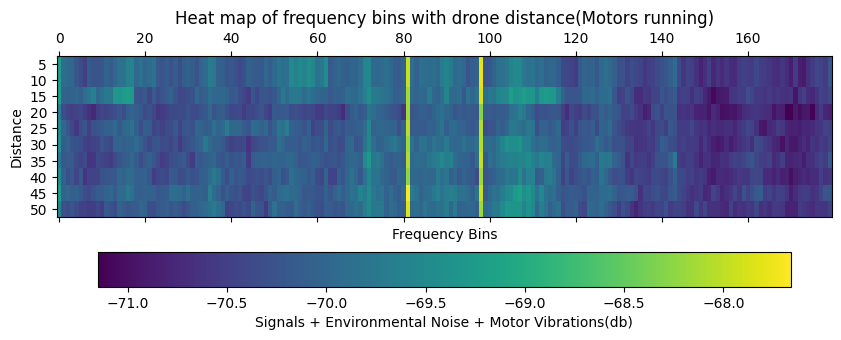

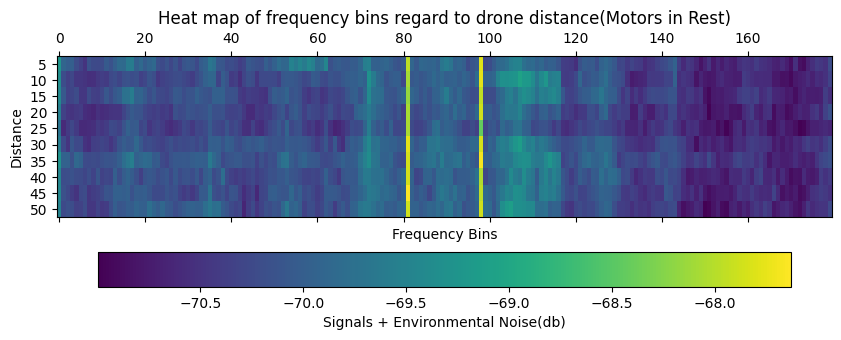

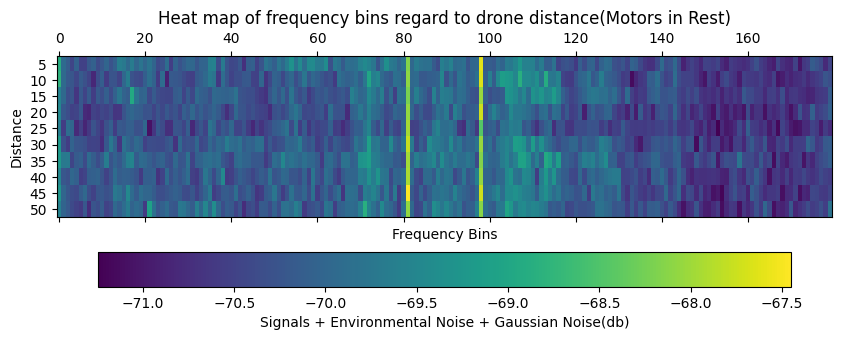

In [12]:
#Generate Heat Map of all dataset based on their distance and noise
get_heat_map(avg_by_bin)

-----------------------------------------------------------------------------------------------
Training Data
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

In [29]:
def get_train_test_data(positive: List, negative: List, testSize=0.2):
    """
    Takes in string or list of string paths to data files for both positive and
    negative examples of our drone_sweep data and returns a train and test
    split of inputs and their labels


    :param positive: the list files containing positive examples
    :param negative: the list of files containing negative examples
    returns a four tuple of x_train, x_test, y_train, y_test
    """
    # 1 for positive examples (drones flying) and 0 for just random noise
    labels = [1.0, 0.0]

    labeled_data = pd.DataFrame()
    for files, label in zip([positive, negative], labels):
        for filename in files:
            new_data = read_drone_sweep_file_and_merge(filename)
            new_data['label'] = label
            labeled_data = labeled_data.append(new_data)

    labels = labeled_data['label']
    inputs = labeled_data.drop('label', axis=1)
    return train_test_split(inputs, labels, test_size=testSize)

In [30]:
def make_svm(x_train: pd.DataFrame, x_test: pd.DataFrame, y_train: pd.DataFrame, y_test: pd.DataFrame):
    clf = SVC(kernel='linear')
    return(clf.fit(x_train, y_train))

In [ ]:

def plot_learning_curve(estimator: SVC, title, X, y):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [31]:
print("=======================================")
print("\n Creating a split of our positive and negative examples for use in learning models: ")
x_train, x_test, y_train, y_test = get_train_test_data(positive=[drone_filename], negative=[noise_filename])
print("=======================================")


 Creating a split of our positive and negative examples for use in learning models: 


C:\Users\riazr\AppData\Local\Temp\ipykernel_32604\661839864.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeled_data = labeled_data.append(new_data)


C:\Users\riazr\AppData\Local\Temp\ipykernel_32604\661839864.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  labeled_data = labeled_data.append(new_data)


In [ ]:
#Optional Run
print("=======================================")
print("Training examples: " + str(x_train.head()) + "\nTraining Labels: " + str(y_train.head()))
x_train.to_csv("filename.csv", sep=',', index=False, encoding='utf-8')
y_train.to_csv("filename1.csv", sep=',', index=False, encoding='utf-8')
print("=======================================")

# **SVM**

Accuracy: 0.56
Precision: 0.54
Recall: 0.56
F1-score: 0.55
Confusion Matrix:
[[279 224]
 [208 264]]


Text(0.5, 1.0, 'SVM Confusion Matrix')

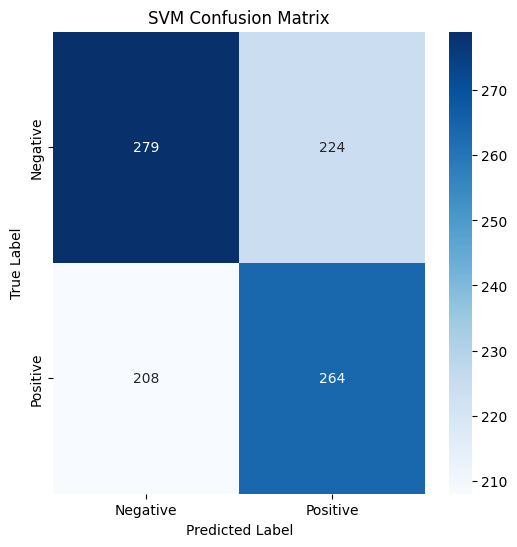

In [37]:
svm=make_svm(x_train, x_test, y_train, y_test)
#plot_learning_curve(svm,"asda",x_train,y_train)
# Make predictions on the test data
svm_y_pred = svm.predict(x_test)

# Calculate performance metrics
svm_accuracy = accuracy_score(y_test, svm_y_pred)
svm_precision = precision_score(y_test, svm_y_pred)
svm_recall = recall_score(y_test, svm_y_pred)
svm_f1 = f1_score(y_test, svm_y_pred)

# Print the performance metrics
print(f"Accuracy: {svm_accuracy:.2f}")
print(f"Precision: {svm_precision:.2f}")
print(f"Recall: {svm_recall:.2f}")
print(f"F1-score: {svm_f1:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, svm_y_pred)
print("Confusion Matrix:")
print(conf_matrix)
class_labels = ['Negative', 'Positive']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')


# **Gradient Boosting (XGBoost model)**

Accuracy: 0.53
Precision: 0.51
Recall: 0.57
F1-score: 0.54
Confusion Matrix:
[[247 256]
 [204 268]]


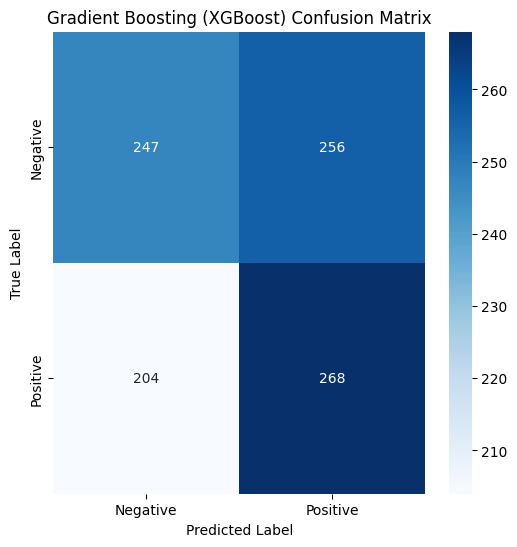

In [36]:
# Create and train the XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(x_test)


# Calculate performance metrics
xgb_accuracy = accuracy_score(y_test, y_pred)
xgb_precision = precision_score(y_test, y_pred)
xgb_recall = recall_score(y_test, y_pred)
xgb_f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print(f"Accuracy: {xgb_accuracy:.2f}")
print(f"Precision: {xgb_precision:.2f}")
print(f"Recall: {xgb_recall:.2f}")
print(f"F1-score: {xgb_f1:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_labels = ['Negative', 'Positive']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Gradient Boosting (XGBoost) Confusion Matrix')
plt.show()

# **Random Forest Classifier(Ensemble)**

Accuracy: 0.55
Precision: 0.54
Recall: 0.56
F1-score: 0.55
Confusion Matrix:
[[273 230]
 [206 266]]


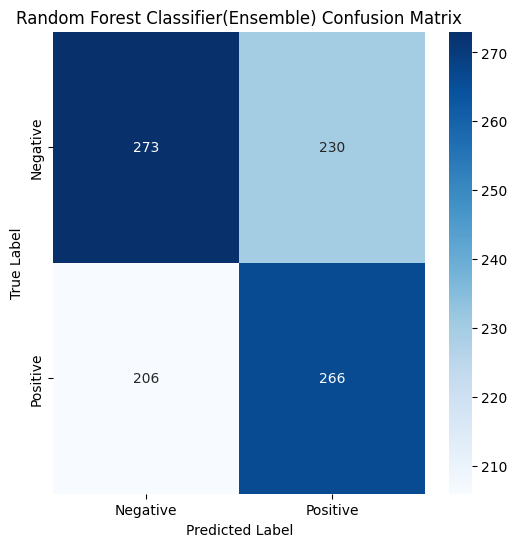

In [34]:
# Create and train the Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(x_test)

# Calculate performance metrics
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

# Print the performance metrics
print(f"Accuracy: {rf_accuracy:.2f}")
print(f"Precision: {rf_precision:.2f}")
print(f"Recall: {rf_recall:.2f}")
print(f"F1-score: {rf_f1:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
# Define class labels (replace with your own class labels if necessary)
class_labels = ['Negative', 'Positive']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Classifier(Ensemble) Confusion Matrix')
plt.show()

# **Comparison between models**

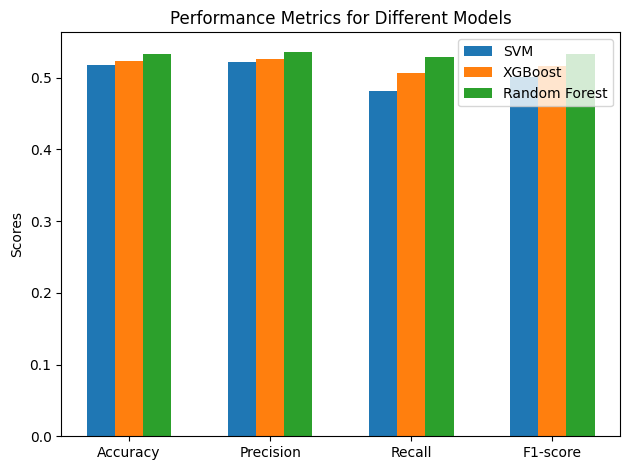

In [ ]:
# Create bar graph for comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
svm_scores = [svm_accuracy, svm_precision, svm_recall, svm_f1]
xgb_scores = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1]
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1]

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, svm_scores, width, label='SVM')
rects2 = ax.bar(x, xgb_scores, width, label='XGBoost')
rects3 = ax.bar(x + width, rf_scores, width, label='Random Forest')

ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()

Testing for RNN

In [25]:
# Reshape x_train to a 3D array with shape (number_of_samples, timesteps, number_of_features)
timesteps = 1
x_train_3d = np.reshape(x_train, (x_train.shape[0], -1, x_train.shape[1]))

# Define the RNN model
model = Sequential()

# LSTM layer with 64 units and input shape (timesteps, number_of_features)
model.add(LSTM(64, input_shape=(timesteps, x_train.shape[1])))

# Dense output layer with 1 unit (for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train_3d, y_train, epochs=10, batch_size=32)

# Assuming you have already split your data into x_test and y_test for evaluation
# Reshape x_test to a 3D array with the same number of timesteps as used during training
x_test_3d = np.reshape(x_test, (x_test.shape[0], timesteps, x_test.shape[1]))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(x_test_3d, y_test)

# Print the test accuracy
print("Test Accuracy:", accuracy)

# Get predictions on the test data
y_pred = model.predict_classes(x_test_3d)

# Calculate the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

ValueError: Must pass 2-d input. shape=(3900, 1, 180)